# 特征工程

## 导入模块

In [27]:
import tensorflow as tf
from tensorflow import keras

import os
import datetime
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print('colors:', colors)

colors: ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


## 导入数据

In [2]:
def func_load_dataframe(input_path, sep=None):
    """
    导入数据，支持自定义
    :param input_path: 输入文件路径
    :param sep: 分隔符
    :return df
    """
    if sep is None:
        sep = '\t'
    df = pd.read_csv(input_path, sep=sep)
    return df

## 数据探索

In [3]:
def func_data_eda(df, target):
    """
    数据简单探索
    :param df: dataframe
    :param target: target
    :return
    """
    print('df.head(): \n', df.head())
    print('-'*52)
    print('df.info(): \n', df.info(show_counts=True))
    print('-'*52)
    print('df.describe(): \n', df.describe(include='all').T)
    print('-'*52)
    print('df.groupby: \n', df.groupby(target, as_index=False)[target].count())

## 数据处理

In [4]:
def func_data_processing_simple(df, useless_features=None, fillna_features=None, log_transform_features=None):
    """
    简单数据处理
    :param df: dataframe
    :param useless_features: 无用特征 list
    :param fillna_features: 缺失值填补 list
    :param log_transform_features: log变换 list
    :return df_copy: new dataframe
    """
    df_copy = df.copy()
    
    if useless_features is not None:
        # 丢掉无用特征
        df_copy.drop(useless_features, axis=1, inplace=True)
    if fillna_features is not None:
        # 填充缺失值
        fill_dict = {key: df_copy[key].mean() for key in fillna_features}
        df_copy.fillna(fill_dict, inplace=True)
    if log_transform_features is not None:
        # log变换
        for feature in log_transform_features:
            df_copy[feature+'_log'] = np.log(df_copy.pop(feature) + 0.001)
    return df_copy

## 计算class weight

In [5]:
def func_calc_class_weight(df, target):
    """
    计算class weight
    :param df
    :param target
    :return  pos, neg, class_weight
    """
    neg, pos = np.bincount(df[target])
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))
    
    weight_for_0 = (1 / neg) * (total / 2.0)  # total / (2*neg)
    weight_for_1 = (1 / pos) * (total / 2.0)  # total / (2*pos)

    class_weight = {
        0: weight_for_0,
        1: weight_for_1
    }
    return pos, neg, class_weight

## 划分训练集、验证集、测试集

In [6]:
def func_train_test_split(df, target, test_ratio=0.2):
    """
    划分训练、验证、测试集
    :param df: dataframe
    :param df: target variable
    :param test_ratio: ratio
    :return train, val, test: dataframe
    """
    train, test = train_test_split(df, test_size=test_ratio, stratify=df[target], random_state=2030)
    train, val = train_test_split(train, test_size=test_ratio, stratify=train[target], random_state=2030)
    
    train.reset_index(drop=True, inplace=True)
    val.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    
    print(len(train), 'train examples')
    print(len(val), 'validation examples')
    print(len(test), 'test examples')
    return train, val, test

## 数据标准化、onehot

In [7]:
def func_data_processing_complex(train, val, test, num_features, category_features):
    """
    复杂数据处理
    :param train: dataframe
    :param val: dataframe
    :param test: dataframe
    :param num_features: 数值型特征
    :param category_featrues: 类别型特征
    :return train, val, test: dataframe
    """
    if len(num_features) > 0:
        train[num_features] = (train[num_features] - train[num_features].mean()) / (train[num_features].std() + 1e-7)
        val[num_features] = (val[num_features] - train[num_features].mean()) / (train[num_features].std() + 1e-7)
        test[num_features] = (test[num_features] - train[num_features].mean()) / (train[num_features].std() + 1e-7)
    if len(category_features) > 0:
        onehot = OneHotEncoder(handle_unknown='ignore')
        onehot.fit(train[category_features].values)
        features_onehot = onehot.get_feature_names(category_features)
        train_onehot = pd.DataFrame(onehot.transform(train[category_features].values).toarray(), columns=features_onehot)
        val_onehot = pd.DataFrame(onehot.transform(val[category_features].values).toarray(), columns=features_onehot)
        test_onehot = pd.DataFrame(onehot.transform(test[category_features].values).toarray(), columns=features_onehot)
        train = pd.concat([train.drop(category_features, axis=1), train_onehot], axis=1)
        val = pd.concat([val.drop(category_features, axis=1), val_onehot], axis=1)
        test = pd.concat([test.drop(category_features, axis=1), test_onehot], axis=1)
    return train, val, test

## 切分target和features

In [8]:
def func_split_features_target(train, val, test, target, is_array=False):
    """
    切分target和features
    :param train:
    :param val:
    :param test:
    :param target:
    :param is_array: 是否转换成array
    :return train_features, train_labels, val_features, val_labels, test_features, test_labels
    """
    # Form np arrays of labels and features.
    train_labels = train.pop(target)
    val_labels = val.pop(target)
    test_labels = test.pop(target)
    
    train_features = train
    val_features = val
    test_features = test
    
    if is_array:
        train_features, val_features, test_features = np.array(train_features), np.array(val_features), np.array(test_features)
        train_labels, val_labels, test_labels = np.array(train_labels), np.array(val_labels), np.array(test_labels)
    return train_features, train_labels, val_features, val_labels, test_features, test_labels

## plot 混淆矩阵

In [34]:
def func_plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

## plot roc

In [35]:
def func_plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
#     plt.xlim([-0.5,20])
#     plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.show()

## plot pr curve

In [36]:
def func_plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.show()

# LR模型=基于sklearn

### 模型训练

In [37]:
def func_train_model_sklearn(X, y):
    """
    模型训练
    :param X: input features
    :param y: input labels
    :return clf: model
    """
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X, y)
    
    return clf

### main函数

In [38]:
def main_sklearn():
    print('-'*52)
    print('setting path...')
    # 基础设置
    input_path = './lr/creditcard.csv'
    target = 'Class'
    useless_features=['Time']  # 不需要的字段
    fillna_features=['Amount']  # na字段
    log_transform_features=['Amount']  # log变换字段
    num_features=['Amount_log']  # 数值型字段
    category_features=[]  # 类别字段
    
    print('-'*52)
    print('loading data...')
    # 导入数据
    df = func_load_dataframe(input_path, sep=',')
    
    print('-'*52)
    print('data eda...')
    # 数据探索
    func_data_eda(df, target)
#     pos, neg, class_weight = func_calc_class_weight(df, target)
    
    print('-'*52)
    print('data processing simple...')
    # 简单数据处理
    df_copy = func_data_processing_simple(df, useless_features, fillna_features, log_transform_features)
    
    print('-'*52)
    print('train val test split...')
    # 划分训练集、验证集、测试集
    train, val, test = func_train_test_split(df_copy, target)
    
    print('-'*52)
    print('data processing complex...')
    # 复杂数据处理
    train, val, test = func_data_processing_complex(train, val, test, num_features, category_features)
    
    print('-'*52)
    print('split target features...')
    # 切分target和features
    train_features, train_labels, val_features, val_labels, test_features, test_labels = func_split_features_target(train, val, test, target)
    
    print('-'*52)
    print('model train with sklearn...')
    # 模型训练
    clf = func_train_model_sklearn(train_features, train_labels)
    
    print('-'*52)
    print('predict...')
    # 预测
    train_predictions = clf.predict_proba(train_features)[:, 1]
    test_predictions = clf.predict_proba(test_features)[:, 1]
    
    print('-'*52)
    print('plot confuse matrix...')
    # 画混淆矩阵
    func_plot_cm(test_labels, test_predictions)
    
    print('-'*52)
    print('plot roc curve...')
    # 画roc
    func_plot_roc('test', test_labels, test_predictions, color='blue')
    
    print('-'*52)
    print('plot pr curve...')
    # 画pr
    func_plot_prc('test', test_labels, test_predictions, color='blue')
    
    print('-'*52)
    print('done...')
    return

----------------------------------------------------
setting path...
----------------------------------------------------
loading data...
----------------------------------------------------
data eda...
df.head(): 
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 

/home/meiyunhe/softwares/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


----------------------------------------------------
predict...
----------------------------------------------------
plot confuse matrix...


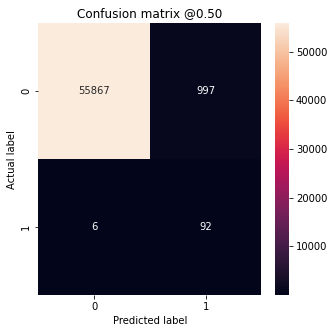

Legitimate Transactions Detected (True Negatives):  55867
Legitimate Transactions Incorrectly Detected (False Positives):  997
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  92
Total Fraudulent Transactions:  98
----------------------------------------------------
plot roc curve...


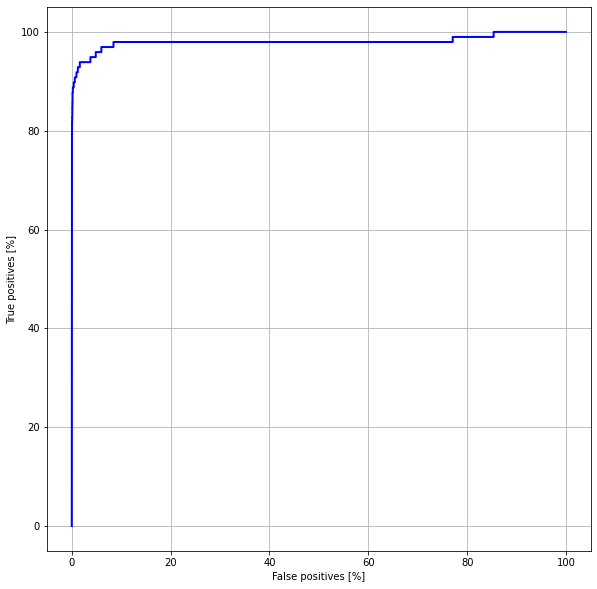

----------------------------------------------------
plot pr curve...


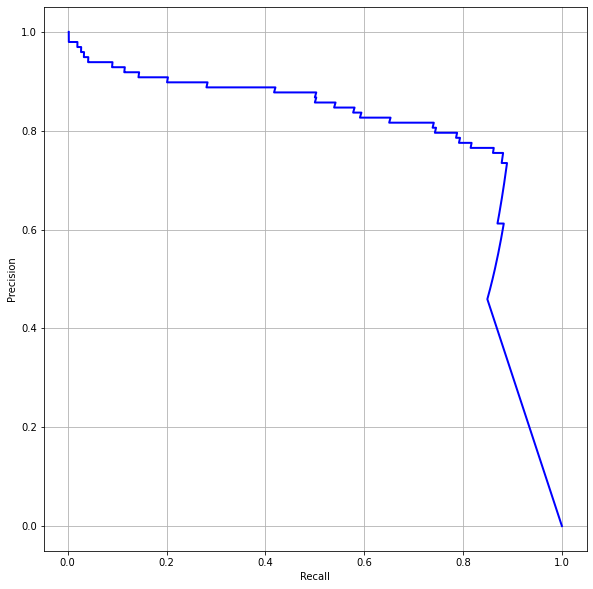

----------------------------------------------------
done...


In [39]:
main_sklearn()

# LR模型=基于TensorFlow

### 定义模型

In [9]:
def func_make_model_with_tf(n_x, metrics=None, output_bias=None):
    """
    :param n_x: 输入特征维度
    :param metrics:
    :param output_bias:
    :return model
    """
    if metrics is None:
        metrics = [
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'),
            keras.metrics.BinaryAccuracy(name='acc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.AUC(name='prc', curve='PR'),
        ]
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential([
        keras.layers.Dense(1, activation='sigmoid', input_shape=(n_x, ), bias_initializer=output_bias),
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    model.summary()
    return model

### 定义config

In [10]:
# 自定义printlog
class PrintTrainLog(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('epoch: {}, logs: {}'.format(epoch, logs))
#         print('-'*52)

In [11]:
def func_setting_config_tf(df, target):
    """
    setting config
    :param df
    :param target
    :return epochs, batch_size, early_stopping, correct_initial_bias, class_weight, metrics
    """
    epochs = 100
    batch_size = 2048
    
    metrics = [
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'),
            keras.metrics.BinaryAccuracy(name='acc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.AUC(name='prc', curve='PR'),
        ]

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc',
                                                      verbose=1,
                                                      patience=10,
                                                      mode='max',
                                                      restore_best_weights=True)
    
    pos, neg, class_weight = func_calc_class_weight(df, target)
    correct_initial_bias = np.log([pos/neg])
    return epochs, batch_size, early_stopping, correct_initial_bias, class_weight, metrics

### plot model history

In [19]:
def func_plot_metrics_tf(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='blue', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            pass
#             plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        elif metric == 'recall':
            plt.ylim([0,1])
        else:
            plt.ylim([0,1])
        plt.legend()
    plt.tight_layout()

### main函数

In [40]:
def main_tf():
    print('-'*52)
    print('setting path...')
    # 基础设置
    input_path = './lr/creditcard.csv'
    target = 'Class'
    useless_features=['Time']  # 不需要的字段
    fillna_features=['Amount']  # na字段
    log_transform_features=['Amount']  # log变换字段
    num_features=['Amount_log']  # 数值型字段
    category_features=[]  # 类别字段
    
    print('-'*52)
    print('loading data...')
    # 导入数据
    df = func_load_dataframe(input_path, sep=',')
    
    print('-'*52)
    print('data eda...')
    # 数据探索
    func_data_eda(df, target)
    pos, neg, class_weight = func_calc_class_weight(df, target)
    
    print('-'*52)
    print('data processing simple...')
    # 简单数据处理
    df_copy = func_data_processing_simple(df, useless_features, fillna_features, log_transform_features)
    
    print('-'*52)
    print('train val test split...')
    # 划分训练集、验证集、测试集
    train, val, test = func_train_test_split(df_copy, target)
    
    print('-'*52)
    print('data processing complex...')
    # 复杂数据处理
    train, val, test = func_data_processing_complex(train, val, test, num_features, category_features)
    
    print('-'*52)
    print('split target features...')
    # 切分target和features
    train_features, train_labels, val_features, val_labels, test_features, test_labels = func_split_features_target(train, val, test, target)
    
    print('-'*52)
    print('model config...')
    # 定义模型config
    epochs, batch_size, early_stopping, correct_initial_bias, class_weight, metrics = func_setting_config_tf(df, target)
    
    print('-'*52)
    print('model define...')
    # 模型定义
    model = func_make_model_with_tf(n_x=train_features.shape[-1], metrics=metrics, output_bias=correct_initial_bias)
    
    print('-'*52)
    print('model train...')
    # 模型训练
    model_history = model.fit(train_features, train_labels, 
                              batch_size=batch_size, epochs=epochs, 
                              callbacks=[early_stopping, PrintTrainLog()], 
                              validation_data=(val_features, val_labels),
                              # the class weights go here
                              class_weight=class_weight, verbose=0)
    
    print('-'*52)
    print('plot model history...')
    # 画指标图
    func_plot_metrics_tf(model_history)
    
    print('-'*52)
    print('predict...')
    # 预测
    train_predictions = model.predict(train_features, batch_size)
    test_predictions = model.predict(test_features, batch_size)
    
    print('-'*52)
    print('plot confuse matrix...')
    # 画混淆矩阵
    func_plot_cm(test_labels, test_predictions)
    
    print('-'*52)
    print('plot roc curve...')
    # 画roc
    func_plot_roc('test', test_labels, test_predictions, color='blue')
    
    print('-'*52)
    print('plot pr curve...')
    # 画pr
    func_plot_prc('test', test_labels, test_predictions, color='blue')
    
    print('-'*52)
    print('done...')
    return

----------------------------------------------------
setting path...
----------------------------------------------------
loading data...
----------------------------------------------------
data eda...
df.head(): 
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 

/home/meiyunhe/softwares/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


epoch: 0, logs: {'loss': 6.3127570152282715, 'tp': 1.0, 'fp': 443.0, 'tn': 181518.0, 'fn': 314.0, 'acc': 0.9958469867706299, 'precision': 0.0022522523067891598, 'recall': 0.0031746032182127237, 'auc': 0.43720343708992004, 'prc': 0.00139704963658005, 'val_loss': 0.02690170146524906, 'val_tp': 0.0, 'val_fp': 72.0, 'val_tn': 45418.0, 'val_fn': 79.0, 'val_acc': 0.9966863393783569, 'val_precision': 0.0, 'val_recall': 0.0, 'val_auc': 0.47027918696403503, 'val_prc': 0.00151462119538337}
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
----------------------------------------------------
plot model history...
----------------------------------------------------
predict...
----------------------------------------------------
plot confuse matrix...


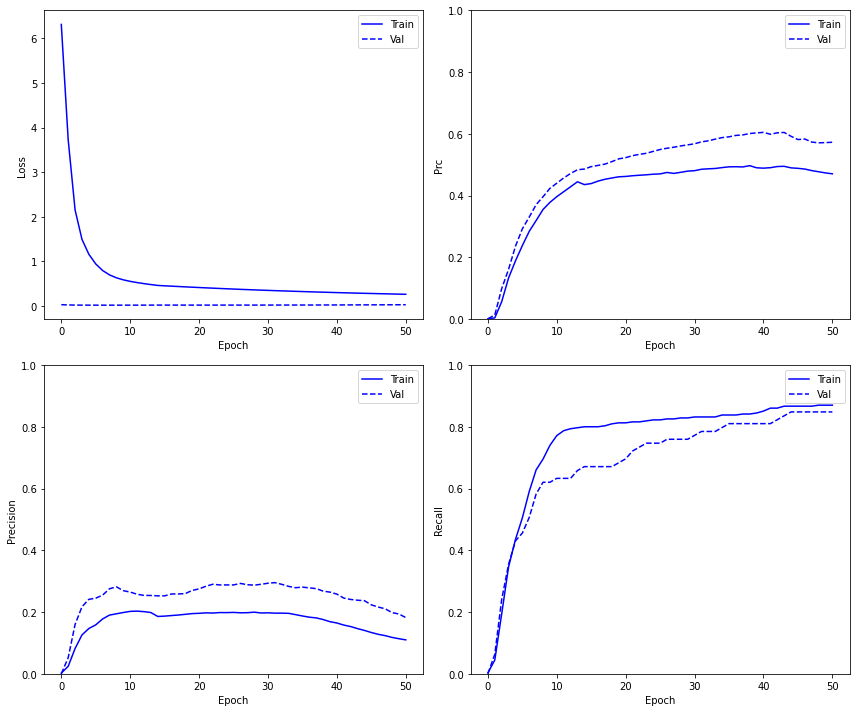

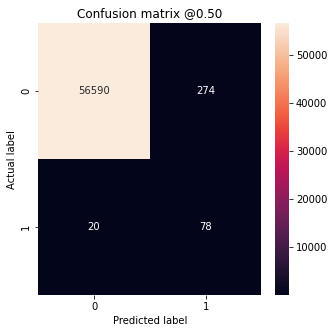

Legitimate Transactions Detected (True Negatives):  56590
Legitimate Transactions Incorrectly Detected (False Positives):  274
Fraudulent Transactions Missed (False Negatives):  20
Fraudulent Transactions Detected (True Positives):  78
Total Fraudulent Transactions:  98
----------------------------------------------------
plot roc curve...


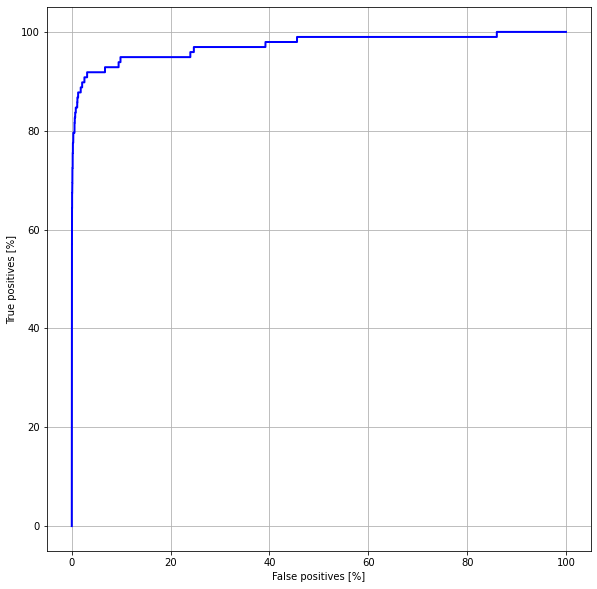

----------------------------------------------------
plot pr curve...


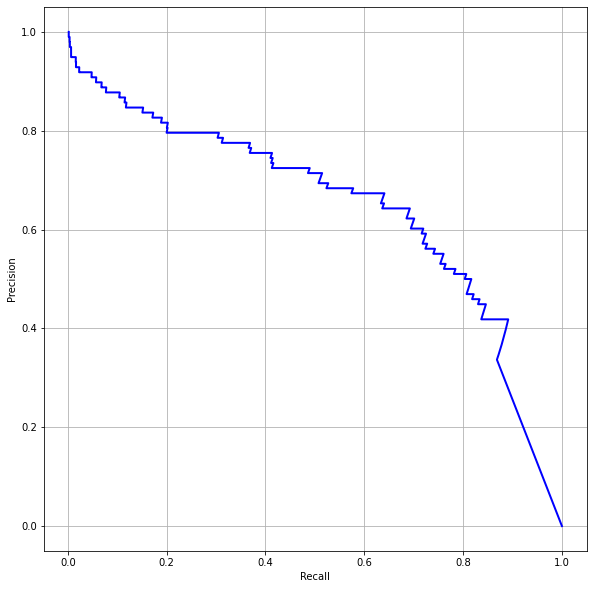

----------------------------------------------------
done...


In [41]:
main_tf()